In [1]:
from __future__ import print_function
import os
import numpy as np
from numpy import newaxis
from sklearn import preprocessing
np.random.seed(1337)

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout
from keras.models import Model,Sequential
from keras.layers import LSTM
import sys

import pandas as pd
import random

Using TensorFlow backend.


# Reading in data

In [2]:
print("Data read started...")
data = pd.read_csv("result9.csv")
data = data.as_matrix()
print ("Data read finished.")

touch_only = 'false'
touch_heart = 'false'

print(data.shape)

Data read started...
Data read finished.
(313, 15)


# Delete irrelevant data

In [3]:
data = np.delete(data, 13, 1)    
data = np.delete(data, 12, 1)   
data = np.delete(data, 11, 1)  
data = np.delete(data, 4, 1)    
data = np.delete(data, 3, 1)     
data = np.delete(data, 2, 1)   
data = np.delete(data, 1, 1)   
data.shape

if(touch_only == 'true'):
    data = np.delete(data, 7, 1)   
    data = np.delete(data, 3, 1)    
    data = np.delete(data, 2, 1)   

if(touch_heart == 'true'):
    data = np.delete(data, 7, 1)   
    
data.shape

one = 0
two = 0
three = 0

for i in range(len(data)):
    if (data[i, 0] == 'NbackSym1'):
        one = one + 1
    if (data[i, 0] == 'NbackSym2'):
        two = two + 1
    if (data[i, 0] == 'NbackSym3'):
        three = three + 1

print(' one: ', one, ' two: ', two, ' three: ', three)

 one:  98  two:  104  three:  111


# Dictionary for the levels

In [4]:
level=["NbackSym1","NbackSym2","NbackSym3"]
level2int = dict((p, i) for i, p in enumerate(level))
int2level = dict((i, p) for i, p in enumerate(level))

# Z normalize

In [5]:
for i in range (1,data.shape[1]):
    data[:, i] = preprocessing.scale(data[:, i])

back1 = np.zeros((one,data.shape[1]-1))
back2 = np.zeros((two,data.shape[1]-1))
back3 = np.zeros((three,data.shape[1]-1))
j = 0
k = 0
l = 0

for i in range(len(data)):
    if (data[i, 0] == 'NbackSym1'):
        back1[j] = data[i, 1:]
        j = j+1
    if (data[i, 0] == 'NbackSym2'):
        back2[k] = data[i, 1:]
        k = k+1
    if (data[i, 0] == 'NbackSym3'):
        back3[l] = data[i, 1:]
        l = l+1

y_data = data[:, 0]
for i in range(len(data)):
    y_data[i] = level2int[y_data[i]]

/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConve

# One-hot encoding

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
one_hot = ohe.fit_transform(y_data.reshape(-1,1)).toarray()

# Group data for recurrent network

In [7]:
window = 10
null = np.array([0,0,0,0,0,0,0])

for i in range(window-1):
        back1 = np.vstack([back1, null])
        back2 = np.vstack([back2, null])
        back3 = np.vstack([back3, null])
        
for i in range(window-1):
        back1 = np.vstack([null, back1])
        back2 = np.vstack([null, back2])
        back3 = np.vstack([null, back3])

data_length = len(back1) + window - 1 + len(back2) + window - 1 + len(back3) + window - 1

x_data = np.zeros((data_length,window, back1.shape[1]))         # final input data for the network
y_one_hot = np.zeros((data_length,one_hot.shape[1]))             # to store one-hot data groupped


for i in range(len(back1)-window):
    for j in range(window):
        x_data[i, j, :] = back1[i+j]
    y_one_hot[i] = [0,0,1]
    

index = 0
for i in range(len(back1)-window, len(back1)-window+ len(back2)-window):
    for j in range(window):
        x_data[i, j, :] = back2[index+j]
    y_one_hot[i] = [0,1,0]
    index = index+1

index = 0
for i in range(len(back1)-window+ len(back2)-window, len(back1)-window + len(back2)-window + len(back3)-window):
    for j in range(window):
        x_data[i, j, :] = back3[index+j]
    y_one_hot[i] = [1,0,0]
        
    index = index+1

# Shuffle data

In [8]:
indices = np.arange(x_data.shape[0])
np.random.shuffle(indices)

x_data = x_data[indices]
y_one_hot = y_one_hot[indices]

# Divide into train, validation and test data

In [9]:
len_data = len(x_data)

nb_test = int(len_data*0.15)
nb_validation = int(len_data*0.15)
nb_train = int(len_data*0.7)

end_valid = nb_train+nb_validation

x_train = x_data[0:nb_train]
y_train = y_one_hot[0:nb_train]

x_valid = x_data[nb_train:end_valid]
y_valid = y_one_hot[nb_train:end_valid]

x_test = x_data[end_valid:]
y_test = y_one_hot[end_valid:]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(275, 10, 7) (275, 3) (59, 10, 7) (59, 3) (60, 10, 7) (60, 3)


# Build the net

In [10]:
model = Sequential()

earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')

model.add(LSTM(64, input_dim=back1.shape[1], input_length=window, return_sequences=True))
model.add(Dropout(0.5))
    

model.add(LSTM(40,return_sequences=False))
model.add(Dropout(0.25))

model.add(Dense(output_dim=y_one_hot.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [11]:
model.fit(x_train, y_train, nb_epoch=200, shuffle=True, callbacks=[earlyStopping], 
          validation_data = (x_valid, y_valid), batch_size=50)

Train on 275 samples, validate on 59 samples
Epoch 1/200
275/275 [==============================] - 2s - loss: 0.8522 - acc: 0.5345 - val_loss: 0.7182 - val_acc: 0.4746
Epoch 2/200
275/275 [==============================] - 0s - loss: 0.6804 - acc: 0.6364 - val_loss: 0.6092 - val_acc: 0.5763
Epoch 3/200
275/275 [==============================] - 0s - loss: 0.5727 - acc: 0.6582 - val_loss: 0.5226 - val_acc: 0.6102
Epoch 4/200
275/275 [==============================] - 0s - loss: 0.4985 - acc: 0.6800 - val_loss: 0.4420 - val_acc: 0.7119
Epoch 5/200
275/275 [==============================] - 0s - loss: 0.4030 - acc: 0.7491 - val_loss: 0.3762 - val_acc: 0.7458
Epoch 6/200
275/275 [==============================] - 0s - loss: 0.3412 - acc: 0.8109 - val_loss: 0.3097 - val_acc: 0.7627
Epoch 7/200
275/275 [==============================] - 0s - loss: 0.2791 - acc: 0.8109 - val_loss: 0.2476 - val_acc: 0.7797
Epoch 8/200
275/275 [==============================] - 0s - loss: 0.2255 - acc: 0.8400 

In [12]:
model.evaluate(x_test, y_test, batch_size=50)

60/60 [==============================] - 0s     


[0.0046613254186619697, 1.0]

In [13]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict_classes(x_test)
print(y_pred)

p=model.predict_proba(x_test)

target_names = ['class 0(0back)', 'class 1(1back)', 'class 2(2back)', 'class3(3back)']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

60/60 [==============================] - 0s     
[0 0 1 0 1 0 0 0 0 1 0 0 0 2 0 0 0 0 0 1 1 0 1 2 2 0 2 1 0 2 0 0 1 1 2 0 1
 0 2 0 2 0 2 0 1 1 2 0 0 2 2 2 0 0 0 1 0 0 1 1]
32/60 [===============>..............] - ETA: 0s                precision    recall  f1-score   support

class 0(0back)       1.00      1.00      1.00        32
class 1(1back)       1.00      1.00      1.00        15
class 2(2back)       1.00      1.00      1.00        13

   avg / total       1.00      1.00      1.00        60

[[32  0  0]
 [ 0 15  0]
 [ 0  0 13]]


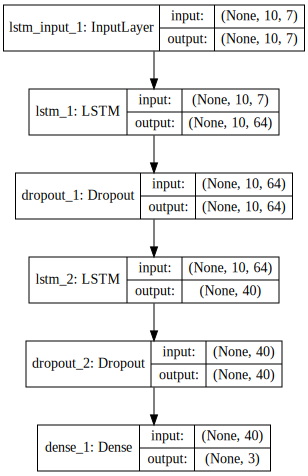

In [14]:
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
plot(model, to_file='model_rnn.png', show_shapes=True)